# Visualization the cell image data

**This notebook shows**

-  **3.1 How single cell images were created and preprocessed**
-  **3.2 How to visualize single cell images**


#### Resources

Libraries we will be using here  - 

- pandas for reading and slicing manifests - https://pandas.pydata.org
- matlpotlib for plotting - https://matplotlib.org
- aicsimageio for image reading - https://github.com/AllenCellModeling/aicsimageio
- nbvv for interactive 3D volume rendering - https://github.com/allen-cell-animated/nbvv
- Cell Feature explorer for interactive image and feature exploration - https://github.com/allen-cell-animated/cell-feature-explorer
- aicsimageprocessing for image processing and visualization utility functions - https://github.com/AllenCellModeling/aicsimageprocessing

First, lets install and load some libraries

In [1]:
!pip install ome-zarr

In [3]:
!sudo pip install git+https://github.com/AllenCellModeling/aicsimageprocessing@d6f7f42005fe4598a531821ee77f2eba5e369301

  Cloning https://github.com/AllenCellModeling/aicsimageprocessing (to revision d6f7f42005fe4598a531821ee77f2eba5e369301) to /tmp/pip-req-build-55i2tvej
  Running command git clone --filter=blob:none --quiet https://github.com/AllenCellModeling/aicsimageprocessing /tmp/pip-req-build-55i2tvej
  Running command git rev-parse -q --verify 'sha^d6f7f42005fe4598a531821ee77f2eba5e369301'
  Running command git fetch -q https://github.com/AllenCellModeling/aicsimageprocessing d6f7f42005fe4598a531821ee77f2eba5e369301
  Resolved https://github.com/AllenCellModeling/aicsimageprocessing to commit d6f7f42005fe4598a531821ee77f2eba5e369301
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.2/438.2 kB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection
from upath import UPath as Path
import warnings
from aicsimageio import transforms, AICSImage
import nbvv
import os
import numpy as np


20-Sep-22 16:09:19 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


# 3.1 **Creating single cell images**

Single cell images were created by first processing FOVs (Fields of Views), followed by additional single cell image preprocessing

## **FOV (Field of View) processing**

For each of the **215,081** single cell images in the dataset, segmentations were computed at the FOV level using the Allen Cell and Structure Segmenter (Chen et al., 2018), with code and trained models available at https://github.com/AllenCell/segmenter_model_zoo. Single cells were extracted from the FOVs using the cell segmentation results. All images were rescaled to isotropic voxel sizes by interpolating along the z dimension to upscale the voxel size from 0.108333 $\mu$m x 0.108333 $\mu$m x 0.29 $\mu$m  to 0.108333 $\mu$m x 0.108333 $\mu$m x 0.108333 $\mu$m. ROIs were determined by extending the 3D bounding box of the cell by 40 pixels in x and y, and 10 pixels in z. FOV processing code is available at https://github.com/AllenCell/cvapipe

In [2]:
# Sample a cell
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
some_cell = df.sample(1).iloc[0]


In [3]:
# Get the protein name for this cell
some_cell['structure_name']

'CETN2'

## **Single cell image preprocessing**

For the sake of the challenge, single cell images were further preprocessed by merging in the cropped brightfield channel, centering and aligning the image to the longest axis of the membrane segmentation channel, and masking by the membrane segmentation channel. Images were further cropped and resized to a global 3D bounding box by taking the 95% quantile of the individual bounding box widths in x, y, and z. The columns **fits_z**, **fits_x**, **fits_y**, indicate whether the image fits the bounding box in that direction. Images that fit the bounding box were padded with 0s, whereas the images that dont were cropped to that size (some information will be lost here, which may be relevant to the challenge). Intensity channels were min-max normalized after clipping intensity values to 95% quantile values . The final registered 3D images were saved as OME Zarr files (paths available via column **registered_path**) and will be the main input images for the challenge. Single cell image preprocessing code associated with the challenge is available at https://github.com/AllenCellModeling/Variance_Data_Processing

In [4]:
# Final images saved under column name "registered path"
full_img = read_ome_zarr(some_cell["registered_path"])

In [5]:
# Inspect whether this image fits the bounding box in z, y, and x
print(some_cell[[i for i in some_cell.index if "fit" in i]])

fits_z    True
fits_y    True
fits_x    True
Name: 67042, dtype: object


In [6]:
# Images have 7 channels for brightfield + DNA, membrane, and structure intensity and segmentation channels
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

Here, we see that images have 7 channels. They are 

- bf - brightfield channel 
- dna - dna intensity channel
- membrane - membrane intensity channel
- structure - structure intensity channel
- dna_segmentation - segmentation of the dna channel
- membrane_segmentation - segmentation of the membrane channel
- struct_segmentation_roof - segmentation of the structure channel

In [206]:
# Lets look at image shape
img_data = full_img.data.squeeze()
print(img_data.shape)

(7, 136, 245, 381)


All images are now of the same size, lending itself to machine learning tasks.

In [8]:
some_cell_1 = df.sample(1).iloc[0]
img_data_1 = read_ome_zarr(some_cell_1["registered_path"]).data.squeeze()

some_cell_2 = df.sample(1).iloc[0]
img_data_2 = read_ome_zarr(some_cell_2["registered_path"]).data.squeeze()
print('Image 1 shape', img_data_1.shape, 'Image 2 shape', img_data_2.shape)

Image 1 shape (7, 136, 245, 381) Image 2 shape (7, 136, 245, 381)


Importantly, the intensity channels in the final registered images were min-max normalized but stored with values between 0 and MX_UINT16 (65535). We can rescale the image such that the background voxels (outside the membrane segmentation mask) become -1 and the remaining voxels become min-max scaled (between 0 and 1)

Text(0.5, 1.0, 'Rescaled')

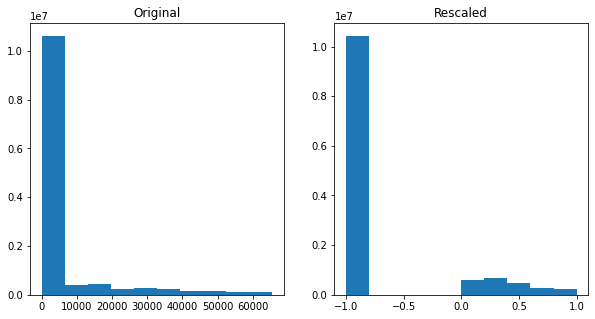

In [9]:
plt.style.use("default")
%matplotlib inline
fig, (ax, ax1) = plt.subplots(1,2, figsize = (10,5))
channel_data = img_data[1]
ax.hist(channel_data.flatten())
ax.set_title('Original')

img_data = rescale_image(img_data, full_img.channel_names)
channel_data_rescaled = img_data[1]
ax1.hist(channel_data_rescaled.flatten())
ax1.set_title('Rescaled')

# 3.2 **Visualizing single cell images**

Single cell images can be visualized in many ways. Here we show 4 ways - using the Cell Feature Explorer (CFE), nbvv, matplotlib, and using diagnostic sheets

## **Using the Cell Feature Explorer to inspect data**

Cell Feature Explorer (https://cfe.allencell.org/?dataset=aics_hipsc_v2021.1) allows you to interactively examine and explore a plot of the full data set with several selected numeric features. We can also directly visualize the original unregistered single cell images and their segmentations using the standalone 3d viewer from Cell Feature Explorer. 

In [100]:
# Generate CFE URL
def generate_url(cell_id):
    print(f"Click this link <a href='https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={cell_id}/>")
cell_id = some_cell['CellId'].item() 
cell_id = 311375
generate_url(cell_id)

Click this link <a href='https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=311375/>


Here, we can select *Full Field* at the top middle of the UI to switch to the FOV view.

## **Using nbvv to inspect registered images**

Normalized 3D images can be viewed using the 3D Volume Viewer **nbvv**, a multichannel viewer for interactively examining volume data.

We display our image with the volshow command. volshow accepts either a 3d or 4d data array. If the array is 4D, it will be treated as multi-channel. We can also tell volshow the physical spacing between the volume pixels in X, Y and Z dimensions (spacing). In our case the data has already been re-scaled to have equal-sized x, y, and z pixels so we just pass in [1,1,1] (the defaults) as an example. We also provide the names of the channels (channel_names) for display. 

Here are some of the main features you will use in the user interface:

- 3D / XY / XZ / YZ Click these buttons to switch between full 3D view and side projections.

- In the side projection modes, you will see one cross-sectional "slice" through the volume at a time.

- You can change the sections you are viewing using the "Clipping" tab at the bottom of the viewport.

- For multi-channel (4D CZYX) data, you can switch displayed channels on and off by clicking the volume checkbox next to each channel. You can also change the colors for each channel by clicking a swatch to the left. Note that the left panel is scrolling, and if you have many channels you may need to scroll. You can do contrast adjustment using the Settings (gear wheel) button for each channel.

In [99]:
nbvv.volshow(
    img_data,
    spacing=[1,1,1],  # full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

VolumeWidget(dimensions={'tile_width': 204, 'tile_height': 136, 'rows': 15, 'cols': 10, 'atlas_width': 2040, '…

The viewer has automatically tried to apply some contrast adjustment, but we could easily pre-apply contrast adjustment by doing math on the data array before passing it to the viewer.  

The viewer will accept any scalar-valued 3d or 4d array we give it.

## **Using matplotlib to visualize image projections**

Image projections can be viewed either by manually projecting along an axis of a single channel, or by loading up one of the projections that have been pre-computed and saved.

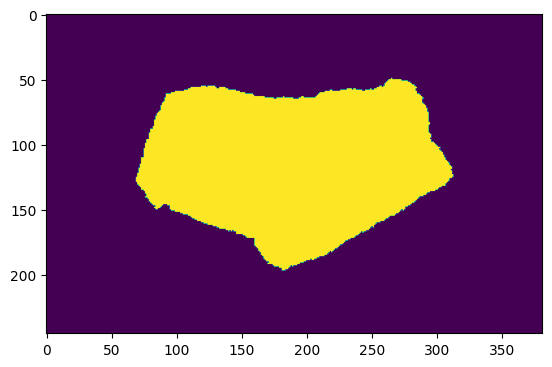

In [15]:
# Manually project a single channel image along a specific axis
# Z projection of the membrane segmentation channel

plt.style.use("default")
plt.imshow(img_data[5].max(axis=0))
plt.show()

Precomputed projections include max projects, mean projects, median projects, and center slices along z, y and x for all channels

In [16]:
projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
]

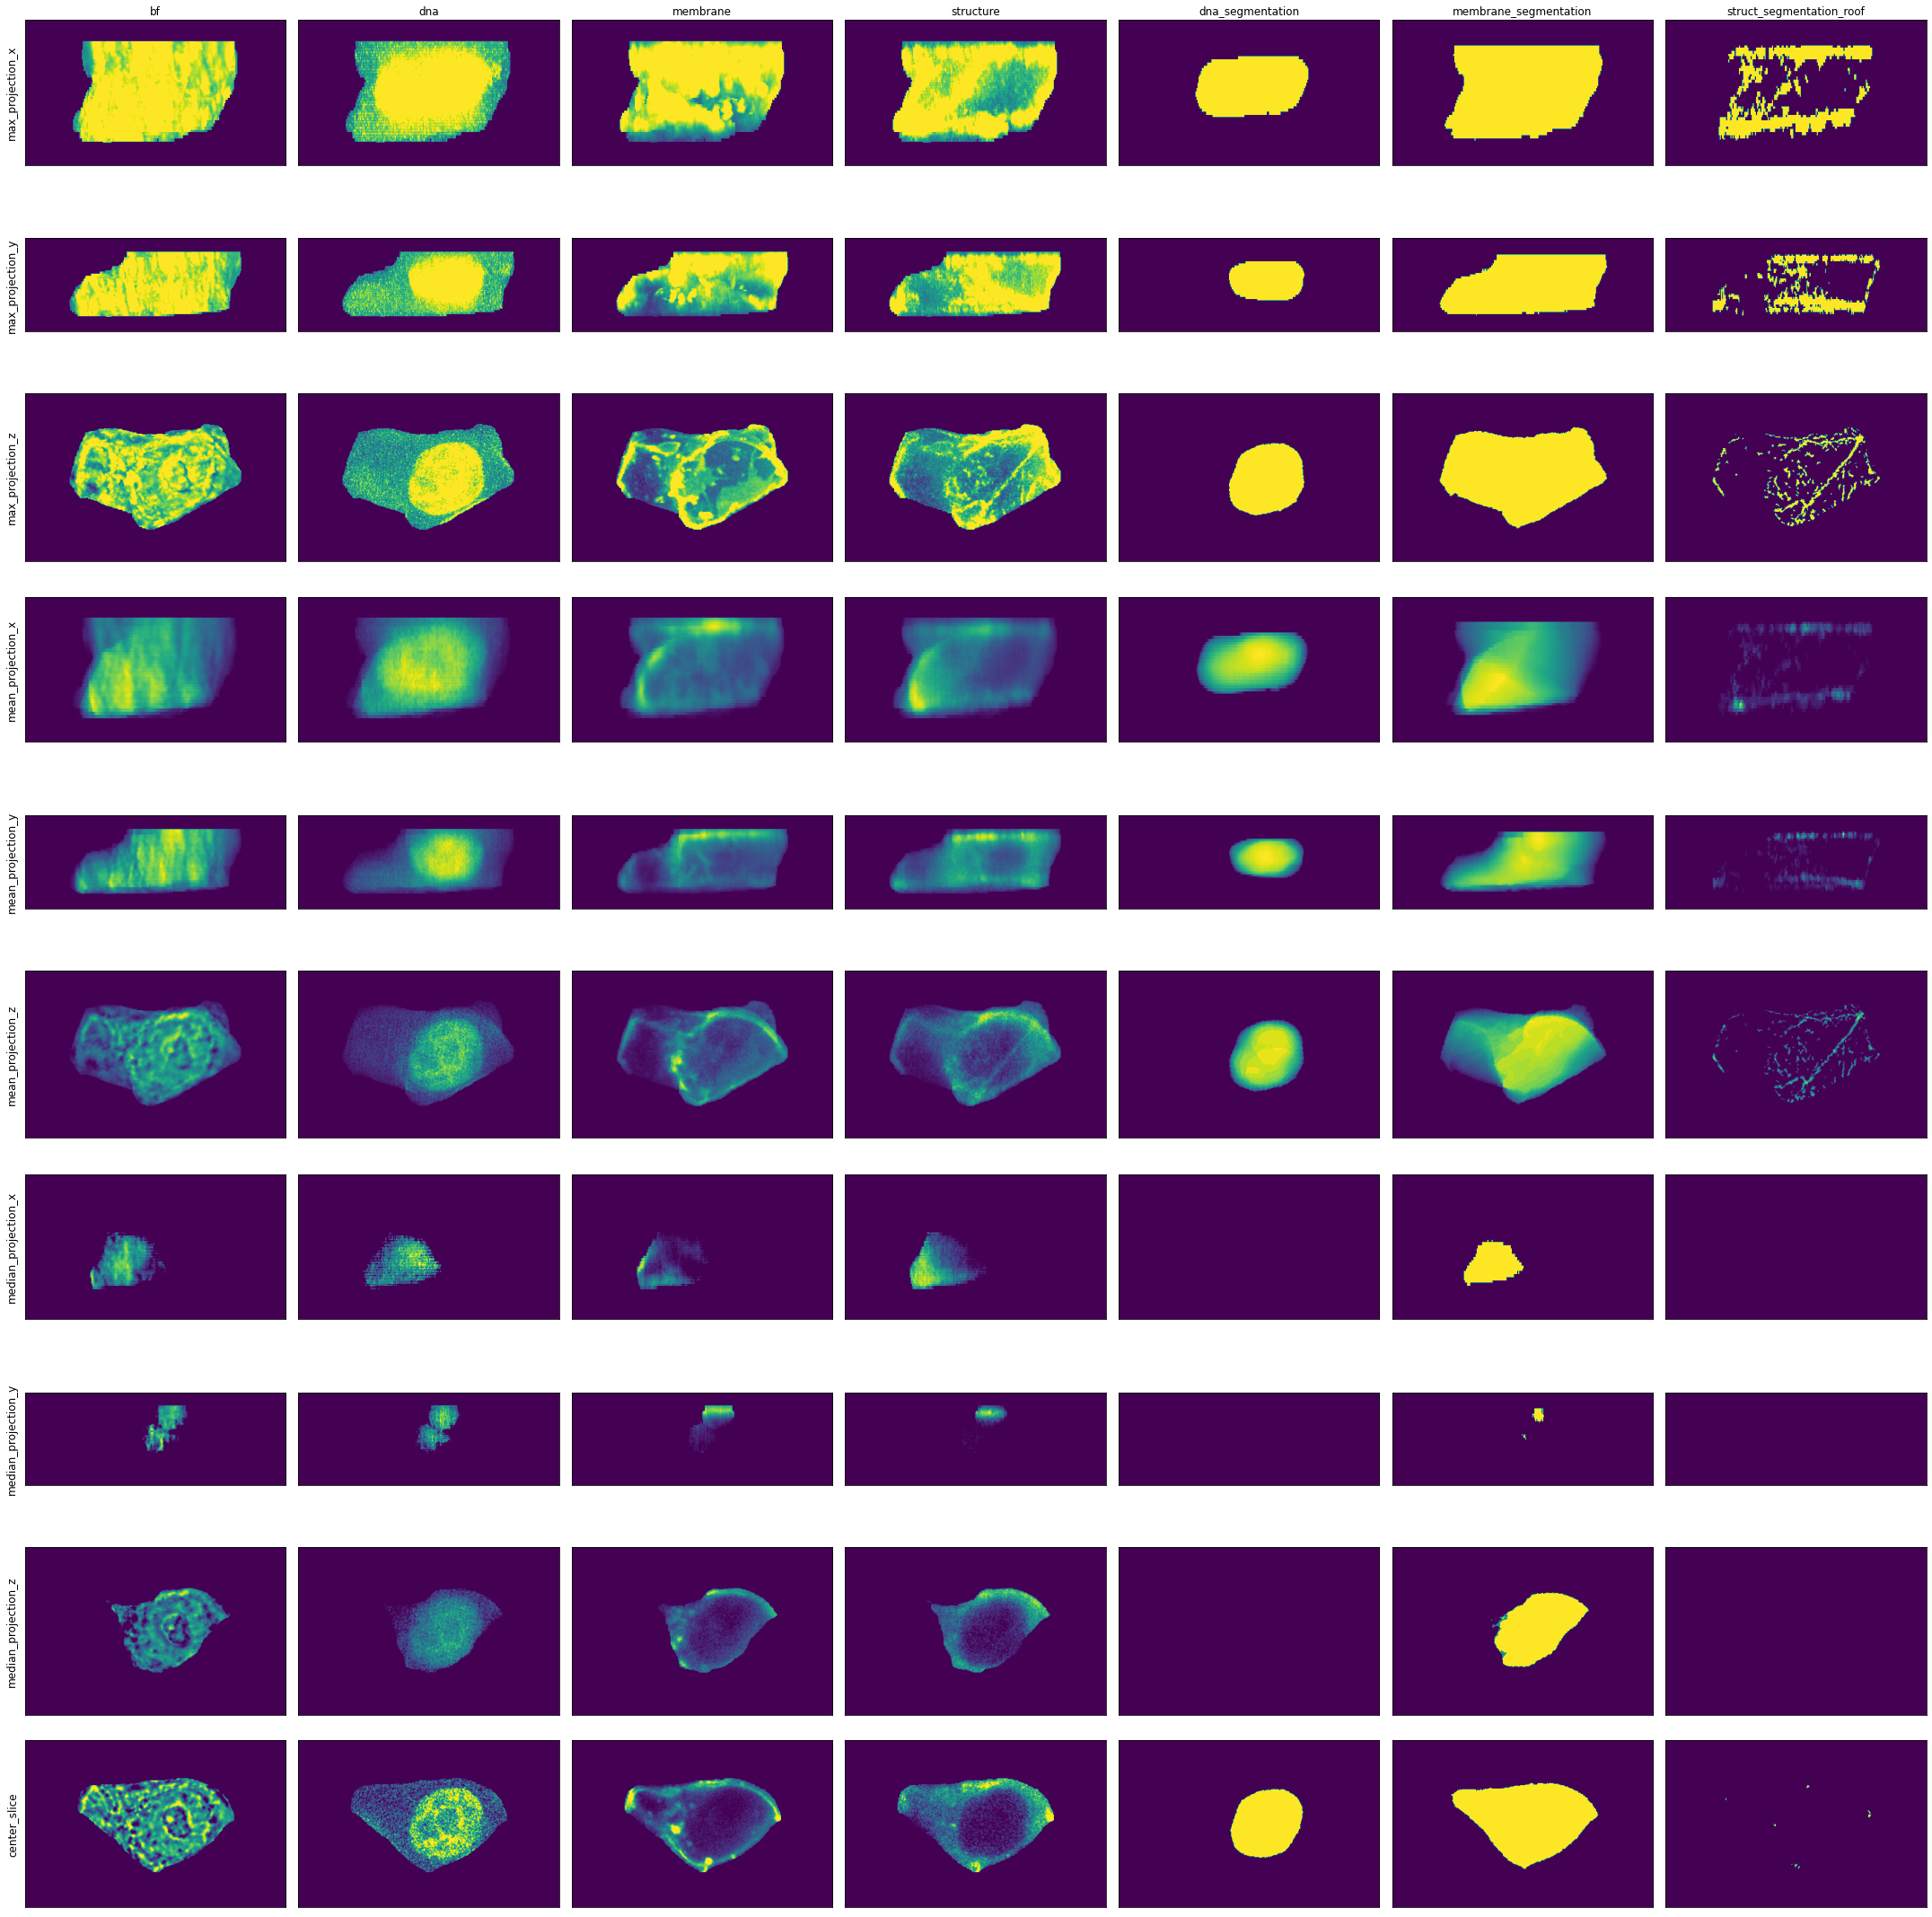

In [17]:
%matplotlib inline
f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix])
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()

To see all 3 projections (XY, YZ, and XZ) in a single image, we can use the **imgtoprojection** function to compute an "all_projection" image. Code associated with this function is available at https://github.com/AllenCellModeling/aicsimageprocessing 

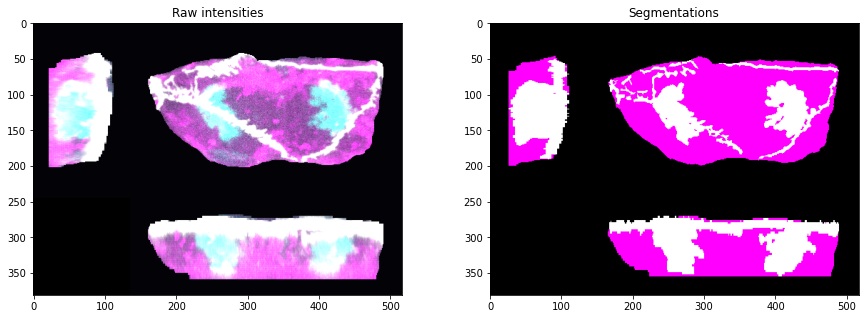

In [221]:

# Lets sample a TJP1 (Tight junction protein) cell in anaphase.
# Cell cycle annotations are - 
# M0 - interphase
# M1M2 - prophase
# M3 - prometaphase
# M4/M5 - metaphase
# M6/M7_single - anaphase with only 1 of the daughters segmented
# M6/M7_complete - anaphase with both daughters segmented

df_mito = df.loc[df['cell_stage'].isin(['M6M7_complete'])]
some_cell = df_mito.loc[df_mito['structure_name'] == 'TJP1'].sample(1).iloc[0]
full_img = read_ome_zarr(some_cell["registered_path"])

# This will set:
# DNA to Cyan
# Membrane to Magenta
# Structure to White
colors = [[0, 1, 1], [1, 0, 1], [1,1,1]]

# Channels 1,2,3 are dna, mem, structure intensities
# Channels 4,5,6 are dna, mem, structure segmentations
channels = {'Raw intensities': [1,2,3], 'Segmentations': [4,5,6]}
fig, axes = plt.subplots(1,2,figsize = (15, 5))

for ind, (key, chan) in enumerate(channels.items()):
    img_data = full_img.get_image_data("CZYX", C=chan)
    chan_names = [full_img.channel_names[i] for i in chan] 
    img_data = rescale_image(img_data, chan_names)
    # Get all axes projection image
    all_proj = imgtoprojection(
        img_data,
        proj_all=True,
        proj_method="max",
        local_adjust=False,
        global_adjust=True,
        colors=colors,
    )
    
    # Convert to YXC for PNG writing
    all_proj = transforms.transpose_to_dims(all_proj, "CYX", "YXC")

    # Drop size to uint8
    all_proj = all_proj.astype(np.uint8)
    axes[ind].imshow(all_proj)
    axes[ind].set_title(key)

Here, we have plotted all 3 projections of the raw intensity channels on the left, and segmentation channels on the right. For each subplot, the top right is the XY projection, the top left is the XZ projection, and the bottom is the YZ projection

## **Using diagnostic sheets to visualize many images**

To visualize many cells that have been stratifed a certain way in a diagnostic sheet, we can use the **diagnostic_sheet** function. Code associated with this function is available at https://github.com/AllenCellModeling/aicsimageprocessing 

In [222]:
# Lets sample 25 cells of LMNB1 and TOMM20

df_sample = df.groupby('structure_name').apply(lambda x: x.sample(25)).reset_index(drop=True)
df_sample = df_sample.loc[df_sample['structure_name'].isin(['LMNB1', 'TOMM20'])]

In [224]:
df_sample.shape

(50, 1242)

In [225]:
# Now we can make diagnostic sheets stratified by structure_name either by computing the "all_projection" image 
# for each cell, or by loading up one of the precomputed projections 
# Here we can also specify a feature to be added as text on the plot
# In this example, we plot nuclear volume (column name NUC_shape_volume)

# This may take some time depending on the number of images being projected
plt.style.use("dark_background")
warnings.simplefilter(action='ignore', category=FutureWarning)

diagnostic_sheet(df_sample, 
                 save_dir = "./", # Created a diagnostic_sheets folder in the current working dir
                 image_column = "registered_path", # Pass in the 3D image path or one of the 2D image paths like max_projection_x
                 max_cells=25, # max cells per sheet
                 channels = [1,2,3], # DNA, Membrane, Structure intensity channels
                 colors = [[0, 1, 1], [1, 0, 1], [1,1,1]], # Cyan, Magenta, White
                 proj_method = "max", # options - max, mean, sum
                 metadata = "structure_name", # Optional, Metadata to stratify the diagnostic sheets
                 feature = "NUC_shape_volume", # Optional, Feature to add as text,
                 fig_width = None, # Default is number of columns * 7
                 fig_height = None, # Default is number of rows * 5,
                 distributed_executor_address = None, # An optional executor address to pass to some computation engine.
                 batch_size = None, # process all at once
                 overwrite=True)




PosixPath('diagnostic_sheets/manifest.csv')

Text(0.5, 1.0, 'LMNB1 cells')

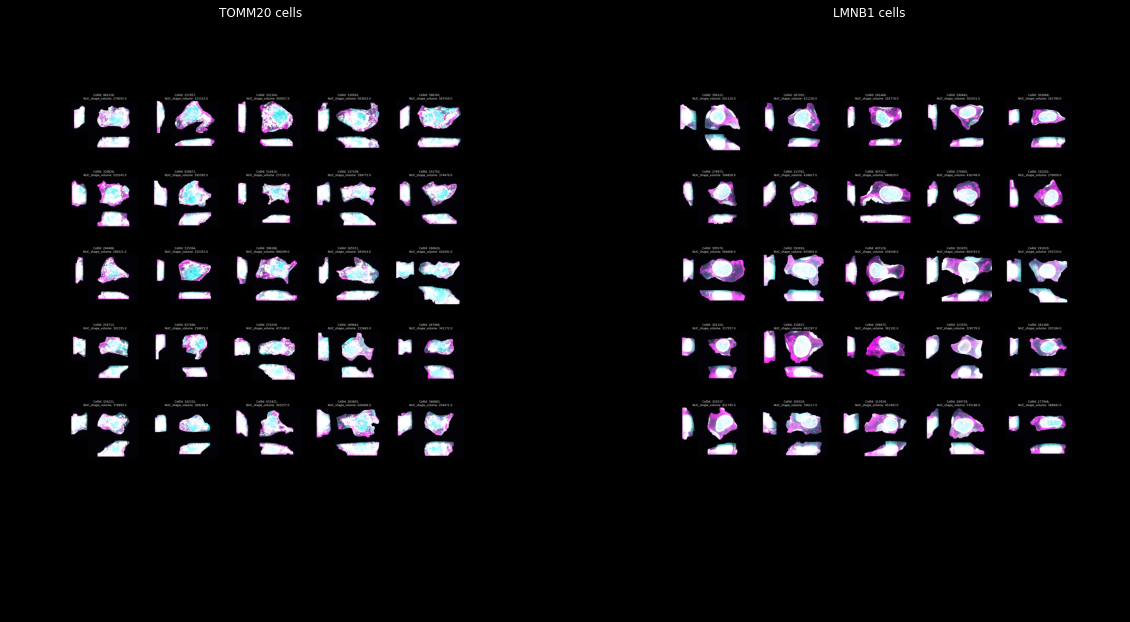

In [226]:
# Lets load up the saved diagnostic sheets and compare LMNB1 and TOMM20 cells
# For a more zoomed in view, click on the image directly and view it in the browser

fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,20))
ax.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "structure_name_TOMM20_1.png"))
ax1.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "structure_name_LMNB1_1.png"))
ax.set_axis_off()
ax.set_title('TOMM20 cells')
ax1.set_axis_off()
ax1.set_title('LMNB1 cells')

Lets say we want to inspect images for edge cells vs non edge cells for differences in height and other aspects of shape. We can do so visually by generating diagnostic sheets for edge vs non edge cells. 

In [228]:
# Can remove the diagnostic sheet directory if you want a clean directory
# import shutil
# import os
# if os.path.isdir(os.getcwd() + "/diagnostic_sheets/"):
#     shutil.rmtree(os.getcwd() + "/diagnostic_sheets/")

In [229]:
# Lets sample 25 cells of center (0) and edge (1) cells

df_sample = df.groupby('edge_flag').apply(lambda x: x.sample(25)).reset_index(drop=True)

In [230]:
df_sample.shape

(50, 1242)

In [231]:
# Now, lets make 2 diagnostic sheets for non edge and edge cells 
# Lets only plot the Y max project
# Lets add membrane height as a feature to the plots
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use("dark_background")

# Here, lets plot segmentation channels instead of intensity channels
# Lets also visualize only the X projection since we are mainly interested in comparing the height 
# Lets also add membrane height feature as text on top of the plots
diagnostic_sheet(df_sample, save_dir = "./", 
                 image_column = "max_projection_x", # Pass in the 3D image path or one of the 2D image paths like max_projection_x
                 max_cells=25, # max cells per sheet
                 channels = [4,5,6], # DNA, Membrane, Structure segmentation channels
                 colors = [[0, 1, 1], [1, 0, 1], [1,1,1]], # Red, Blue, Green
                 proj_method = "max", # max, mean, sum
                 metadata = "edge_flag", # Optional, Metadata to stratify the diagnostic sheets
                 feature = "MEM_position_depth", # Optional, Feature to add as text,
                 fig_width = 15, # Default is number of columns * 7
                 fig_height = 15, # Default is number of rows * 5,
                 distributed_executor_address = None, # An optional executor address to pass to some computation engine.
                 batch_size = None, # process all at once
                 overwrite=True)

PosixPath('diagnostic_sheets/manifest.csv')

Text(0.5, 1.0, 'Edge cells')

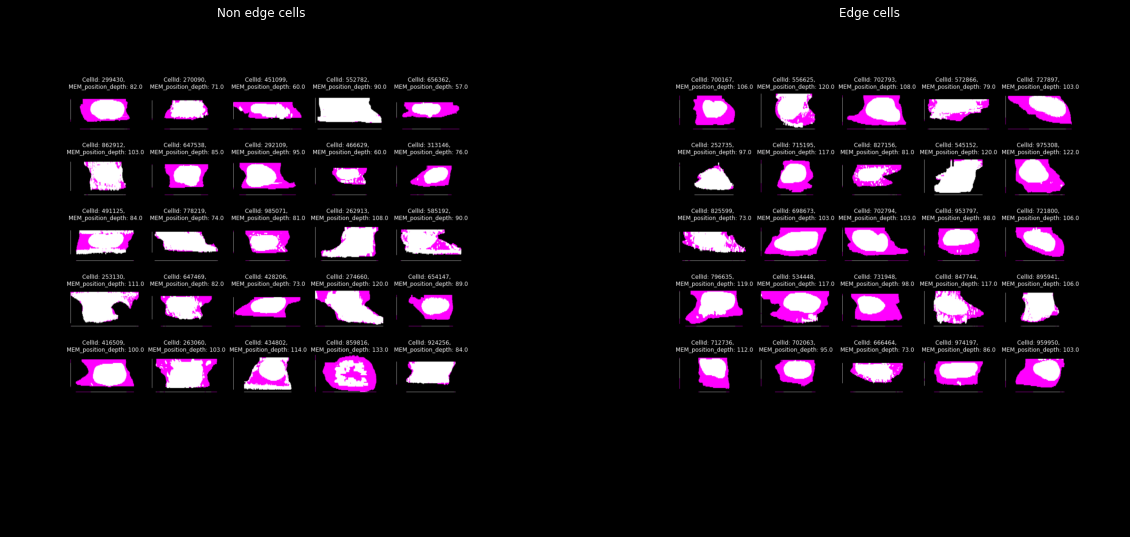

In [232]:
# Lets load up the saved diagnostic sheets and compare edge and non edge cells
# For a more zoomed in view, click on the image directly and view it in the browser
fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,20))
ax.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "edge_flag_0_1.png"))
ax1.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "edge_flag_1_1.png"))
ax.set_axis_off()
ax.set_title('Non edge cells')
ax1.set_axis_off()
ax1.set_title('Edge cells')

We can see visually that edge cells are generally taller than center cells. We can compute the average height per class for the sampled cells and confirm the same. We can also see from the diagnostic sheet that edge cells are
more tilted

In [233]:
# We can see here that non edge cells are flatter than edge cells
df_sample.groupby('edge_flag').mean()['MEM_position_depth']

edge_flag
0     89.00
1    102.48
Name: MEM_position_depth, dtype: float64